## *Problem: Credit Card Fraud Detection*

In [17]:
# 필요한 package loading
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from subprocess import check_output

from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn import mixture

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [18]:
# 데이터 불러오기(Colab)
# Local data upload 시, 주석 처리
from google.colab import files
uploaded = files.upload()

Saving creditcard_split.csv to creditcard_split.csv


In [23]:
# 데이터 불러오기(Colab)
# Local data upload 시, pd.read_csv() 안에 데이터 경로 설정
df = pd.read_csv(io.StringIO(uploaded['creditcard_split.csv'].decode('utf-8')))
del df['Unnamed: 0']
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
# Data split (per class)
df_0 = df[df.Class==0]    # non-fraudulent only
df_1 = df[df.Class==1]    # fraudulent only

# Data split (per sampling ratio)
# non-fraudulent data in 90% for training GMM and 10% for cross-validation and testing
X_N_train, X_N_cv_test, y_N_train, y_N_cv_test = train_test_split(df_0.drop(['Class'],axis=1), df_0['Class'] , test_size=0.1, random_state=1)
# fraudulent data in 50% for cross-validation and 50% for testing
X_F_cv, X_F_test, y_F_cv, y_F_test = train_test_split(df_1.drop(['Class'],axis=1), df_1['Class'] , test_size=0.5, random_state=1)
# the remaining 10% non-fraudulent in 50% for cross-validation and 50% for testing
X_N_cv, X_N_test, y_N_cv, y_N_test = train_test_split(X_N_cv_test, y_N_cv_test , test_size=0.5, random_state=1)

print("===== Train =====")
print(X_N_train.shape)
print(X_F_cv.shape)
print(X_N_cv.shape)

print("===== Test =====")
print(X_N_cv_test.shape)
print(X_F_test.shape)
print(X_N_test.shape)

===== Train =====
(44866, 30)
(74, 30)
(2493, 30)
===== Test =====
(4986, 30)
(74, 30)
(2493, 30)


In [25]:
#Generate the 3 new datasets (Train + CV + test)
X_CV = np.vstack([X_N_cv, X_F_cv])
y_CV = np.hstack([y_N_cv, y_F_cv])
X_test = np.vstack([X_N_test, X_F_test])
y_test = np.hstack([y_N_test, y_F_test])

print(X_CV.shape)
print(y_CV.shape)
print(X_test.shape)
print(y_test.shape)

(2567, 30)
(2567,)
(2567, 30)
(2567,)


In [26]:
'''
Problem 1.
(1) GMM model을 clf 라는 이름으로 정의하시오.
(2) 정의한 GMM model을 'X_N_train' 데이터를 활용해 학습하시오.
'''
clf = mixture.GaussianMixture()
clf.fit(X_N_train)

GaussianMixture()

In [27]:
kfold = StratifiedKFold(n_splits=5)                                   #Create 5-CV split object
T_vec = -np.arange(0,1000,2)                                                            #Trying thresholds in steps of 2, from 0 to -1000. Note we are evaluating the negative log-likelihood.
aucpr_vs_t = []
precision_vs_t = []
recall_vs_t = []

for t in T_vec:

    aucpr=[]
    precision=[]
    recall=[]
    k=0
    for train_index, test_index in kfold.split(X_CV,y_CV):

            y_cv_proba=clf.score_samples(X_CV[test_index])                                 #Predict the probabilities of fold "k" using the fitted GMM
            y_cv_pred=y_cv_proba.copy()
            '''
            Problem 2.
            y_cv_pred 값이 t (threshold) 보다 크면 0으로, t 보다 작으면 1로 구분되도록 설정하시오.
            '''
            y_cv_pred[y_cv_pred>=t]=0
            y_cv_pred[y_cv_pred<t]=1
            precision.append(precision_score( y_CV[test_index], y_cv_pred))
            recall.append(recall_score(y_CV[test_index], y_cv_pred))
            aucpr.append(average_precision_score( y_CV[test_index], y_cv_pred))
            #print("Threshold T = %i --> Fold %i - aucpr=%.3f - Precision=%.3f - Recall=%.3f" %(t, k+1, aucpr[k], precision[k], recall[k]))
            k=k+1


    aucpr_vs_t.append(np.mean(aucpr))
    precision_vs_t.append(np.mean(precision))
    recall_vs_t.append(np.mean(recall))
    #print('CV average AUCPR: %.3f +/- %.3f' % ( np.mean(aucpr), np.std(aucpr)))
    #print('CV average precision: %.3f +/- %.3f' % ( np.mean(precision), np.std(precision)))
    #print('CV average recall: %.3f +/- %.3f' % ( np.mean(recall), np.std(recall)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

In [28]:
# performance measure (average values on k-fold cross validation)

print('CV average AUCPR: %.3f +/- %.3f' % ( np.mean(aucpr), np.std(aucpr)))
print('CV average precision: %.3f +/- %.3f' % ( np.mean(precision), np.std(precision)))
print('CV average recall: %.3f +/- %.3f' % ( np.mean(recall), np.std(recall)))

CV average AUCPR: 0.354 +/- 0.167
CV average precision: 0.842 +/- 0.107
CV average recall: 0.380 +/- 0.160


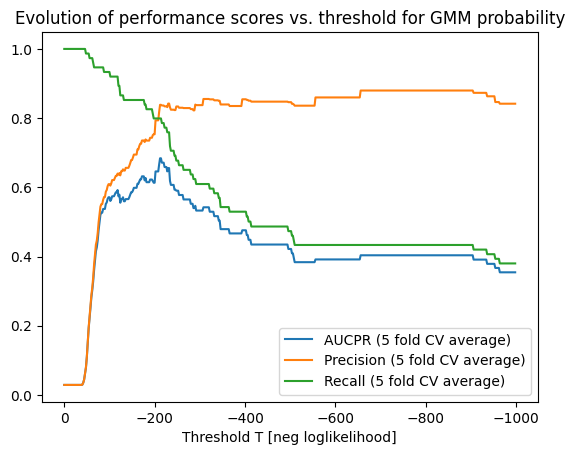

In [29]:
plt.plot(T_vec, aucpr_vs_t)
plt.plot(T_vec, precision_vs_t)
plt.plot(T_vec,recall_vs_t)

ax = plt.gca()
ax.set(title='Evolution of performance scores vs. threshold for GMM probability', xlabel='Threshold T [neg loglikelihood]')
ax.legend(['AUCPR (5 fold CV average)', 'Precision (5 fold CV average)', 'Recall (5 fold CV average)'])
ax.invert_xaxis()

In [30]:
print('Maximum cross validation AUCPR='+str(max(aucpr_vs_t)))

T_opt=T_vec[np.argmax(aucpr_vs_t)]
print('Optimal threshold T = '+str(T_opt))

y_test_proba = clf.score_samples(X_test)
y_test_pred=y_test_proba.copy()
y_test_pred[y_test_pred>=T_opt]=0
y_test_pred[y_test_pred<T_opt]=1

test_precision = (precision_score( y_test, y_test_pred))
test_recall = (recall_score( y_test, y_test_pred))
test_aucpr = (average_precision_score( y_test, y_test_pred))

print("TEST results: aucpr=%.3f, Precision=%.3f, Recall=%.3f" %(test_aucpr, test_precision, test_recall) )

Maximum cross validation AUCPR=0.6839184159684782
Optimal threshold T = -212
TEST results: aucpr=0.584, Precision=0.750, Recall=0.770


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
